In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import ipywidgets as widgets
import numpy as np
import pandas as pd


# global variables go here:


# Metadata support for dataframes:
# (following    https://github.com/pandas-dev/pandas/issues/2485   and
#      http://pandas.pydata.org/pandas-docs/stable/internals.html#override-constructor-properties )
# (consider adding h5 storage, ala
#      http://stackoverflow.com/questions/29129095/save-additional-attributes-in-pandas-dataframe )

# Filepath parsing:
from experimentdataanalysis.parsing.scandataparsing \
    import analyze_scan_filepath, analyze_string_for_dict_pairs
this_element_keyword_list = [("TRKR", "IsTRKR?", True),
                             ("RSA", "IsRSA?", True)]
next_element_keyword_list = [("Ind", "Scan_2D_Index"),
                             ("2Dscan", ["Scan_2D_Type", "Scan_1D_Type"])]
in_this_element_keyword_list = [("Vcm", "Electric Field (V/cm)"),
                                ("mT", "Magnetic Field (mT)"),
                                ("K", "Set Temperature (K)"),
                                ("nm", "Wavelength (nm)"),
                                ("ps", "Delay Time (ps)"),
                                ("run", "RunIndex"),
                                ("V", "Voltage (V)"),
                                ("x", "Scan_2D_Coord"),
                                ("uWpump", "Pump Power (uW)"),
                                ("uWprobe", "Probe Power (uW)"),
                                ("TestPhaseShift", "TestPhaseShift Experiment #"),
                                ("repeats", "# repeats"),
                               ]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

def analyze_filepath_and_header(filepath, header_string, existing_info_dict=None):
    if existing_info_dict is None:
        existing_info_dict = {}
    info_dict = analyze_scan_filepath(filepath, existing_info_dict, parsing_keyword_lists)
    analyze_string_for_dict_pairs(header_string, info_dict)
    if {'Scan_2D_Type', 'Scan_2D_Coord'}.issubset(info_dict.keys()):
        info_dict[info_dict['Scan_2D_Type']] = info_dict['Scan_2D_Coord']
    if 'BExternal' in info_dict.keys():
        info_dict['Magnetic Field (mT)'] = info_dict['BExternal']
    return info_dict

def get_inflection_points(series):
    trend_sign = np.sign(series.iloc[1] - series.iloc[0])
    yvals_iterator = series.items()
    last_yind, last_yval = next(yvals_iterator)  # pop off and add first (ind, val) pair
    inflection_point_indices = [last_yind]
    inflection_point_values = [last_yval]
    for y_ind, y_val in yvals_iterator:
        if np.sign(y_val - last_yval) == -1 * trend_sign:
            trend_sign = -1 * trend_sign
            inflection_point_indices.append(last_yind)
            inflection_point_values.append(last_yval)
        last_yind, last_yval = y_ind, y_val
    inflection_point_indices.append(y_ind)  # add last (ind, val) pair, too
    inflection_point_values.append(y_val)
    return inflection_point_indices, inflection_point_values


In [2]:
# FIT SETUP
from lmfit import Model

# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def get_pulse_sum_vector(spin_lifetime, gfactor, bfield, initial_phase=0):
    """
    Determines effect of summed spins over many pulses and returns the net
    phase and amplitude at zero time delay expected to result. Does not
    take into account any b-field-axis zeeman polarization of spins/nuclei,
    or high-intensity polarization saturation and/or repolarization effects.

    Formulae are from Chris Trowbridge's Ph.D. thesis,
    eqns. 5.12, 5.13, 5.29, and 5.30.

    Does not handle more than one species, so run this function on each
    species individually if possible.

    Expected units:
    polarization: unitless scalar in [0, 1]
    lifetime: ps
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * bfield
    theta = osc_ang_freq * LASER_REPRATE
    x = LASER_REPRATE / spin_lifetime
    net_polarization = 1. / np.sqrt(1 - 2 * np.exp(-x) * np.cos(theta) +
                                    np.exp(-2 * x))
    net_phase = initial_phase + np.arctan((np.exp(-x) * np.sin(theta)) /
                                          (1 - np.exp(-x) * np.cos(theta)))
    return (net_polarization, net_phase)  # at zero delay, of course


def fitfcn_trkr_single_species(delay_time, b_external,  # <- independent variables
                               pulse_amplitude, gfactor,  # <- parameters
                               spin_lifetime, initial_phase,
                               slope, offset):
    zero_delay_offset = 0.0
    trkr_per_unit_polarization = 1.0
    trkr_phase_offset = 0.0
    pos_def_delay = (delay_time + zero_delay_offset) % LASER_REPRATE \
                        - zero_delay_offset
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    net_polarization, net_phase = get_pulse_sum_vector(spin_lifetime,
                                                       gfactor, b_external,
                                                       initial_phase)
    final_phase = (net_phase + pos_def_delay * osc_ang_freq) % (2 * np.pi)
    final_polarization = pulse_amplitude * net_polarization * \
                            np.exp(-pos_def_delay / spin_lifetime)
    signal = trkr_per_unit_polarization * final_polarization * \
                                    np.cos(final_phase + trkr_phase_offset)
    output = signal + delay_time * slope + offset  # NOT pos-definite
    return output

simple_TRKR_model = Model(fitfcn_trkr_single_species,
                          independent_vars=['delay_time', 'b_external'])
# simple_TRKR_model.set_param_hint('pulse_amplitude', vary=True,
#                                  value
#                                  min=0, max=)


In [13]:
# REQUIRED: directory containing 2D scans
parent_dir = ('C:\\Data\\apr2017\\')
#parent_dir = ('C:\\Data\\apr2017\\170411\\')

# REQUIRED: data storage format information
num_headerlines = 4

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
# TODO: EXPAND
run_criteria = 'directory'
if run_criteria is not 'directory':
    raise NotImplementedError("currently only supported run criteria is grouping-by-directory")

# OPTIONAL: info_dict-based filtering, fcns returning False if data should be ignored
filter_fcns = [
               lambda info_dict: info_dict.get("TestPhaseShift Experiment #") == 2,
#               lambda info_dict: info_dict.get("# repeats", 1) <= 2,
               lambda info_dict: "alignment" not in info_dict.get("Filepath"),
              ]

# OPTIONAL: specify a scalar value to be used as the measurement error of given y-values, i.e., their "error bars"
data_fixed_uncertainty = None


# LOAD AND NOMINALLY FILTER DATA:
unfiltered_filepath_list = []
file_metadata_list = []
file_dataframes_list = []
for dirpath, dirnames, filenames in os.walk(parent_dir):
    for filename in filenames:
        if filename_key in filename:
            unfiltered_filepath_list.append(os.path.join(dirpath, filename))

last_dir = ''
run_counter = -1
filtered_file_list_index = 0
for filepath in unfiltered_filepath_list:
    with open(filepath) as file_lines_iterator:
        header_lines = [next(file_lines_iterator) for line in range(num_headerlines)]
        file_metadata = analyze_filepath_and_header(filepath, ''.join(header_lines))
        file_dataframe = pd.read_csv(filepath_or_buffer=file_lines_iterator,
                                     header=0,
                                     index_col=False,  # no auto-index, needed when tabs at end of each line
                                     sep='\t',
                                     skiprows=0)
        if not all([filter_fcn(file_metadata) for filter_fcn in filter_fcns]):
            continue
        file_dataframe['file_index'] = filtered_file_list_index
        filtered_file_list_index += 1

        # determine Run ID
        if run_criteria == 'directory':
            current_dir = filepath.split('\\')[-2]
            if current_dir != last_dir:
                last_dir = current_dir
                run_counter += 1
            file_metadata['Run ID'] = run_counter
        
        file_dataframes_list.append(file_dataframe)
        file_metadata_list.append(file_metadata)

    

In [5]:
file_dataframes_list[0].head()

,scancoord,lockin2x,lockin1x,lockin2r,lockin1r,laserpower,cwetalon,lasercomponent1,lasercomponent2,temperature,file_index
0,-500.1108,0.000090,0.00092,0.000090,0.00092,0.691,-0.173,0.393,0.001,10.003,0
1,-400.1108,0.000045,-0.00026,0.000050,0.00026,0.688,-0.230,0.395,-0.382,10.003,0
2,-300.1108,0.000010,-0.00132,0.000020,0.00130,0.682,-0.175,0.001,-0.376,10.005,0
3,-200.1108,-0.000005,-0.00186,0.000015,0.00186,0.693,-0.175,0.394,0.001,10.008,0
4,-100.1108,0.000020,-0.00144,0.000020,0.00144,0.678,-0.193,0.001,-0.005,10.002,0


In [6]:
file_metadata_list[0]

{'# repeats': 1.0,
 'Acquisition Program': 'GeneralScanner',
 'BExternal': 0.204,
 'File Last Modified': 'Tue Apr 11 22:23:21 2017',
 'Filepath': 'C:\\Data\\apr2017\\170411\\TestPhaseShift5_0093uWpump_TRKR_noresetdelay_1repeats___818.01nm_10K_2Dscan_BExternal_DelayTime\\Ind_10_DelayTime -500_to_-100 BExternal 0.204x.dat',
 'IsTRKR?': True,
 'Key': 'Value',
 'Magnetic Field (mT)': 0.204,
 'Pump Power (uW)': 93.0,
 'Run ID': 0,
 'Scan_1D_Type': 'DelayTime',
 'Scan_2D_Coord': 0.204,
 'Scan_2D_Index': 10.0,
 'Scan_2D_Type': 'BExternal',
 'Set Temperature (K)': 10.0,
 'TestPhaseShift Experiment #': 5.0,
 'Wavelength (nm)': 818.01}

In [7]:
# pare down to just data columns what we care about 
# but add all relevant metadata as columns itself

# SEMI-REQUIRED: column-generation options. may be required to prevent loss of important data
# on a level finer than the "run" (e.g. filenames for individual csv's)
info_tag_to_column_list = [('Magnetic Field (mT)', 'b_external'),
                           ('BExternal', 'b_external'),
                           ('Run ID', 'run_id'),
                           ('Scan_2D_Index', 'index_2d'),
                           ('Pump Power (uW)', 'pump_power'),
                           ('Wavelength (nm)', 'wavelength'),
                           ('# repeats', 'n_repeats')
                          ]
time_elapsed_per_delay_scan = 8.0
time_elapsed_per_delay_pos = 1.0
column_expression_list = ['index_2d = index_2d - 1',  # filename convention starts at 1, not at 0 like other indices
                          'index_1d = index',
                          'time_elapsed = ' +
                              '@time_elapsed_per_delay_scan * index_2d + @time_elapsed_per_delay_pos * index_1d',
                         ]

# OPTIONAL: specification of specific columns in data file as x-coords, y-coords. 
#           default: X = 1st column in file, Y = 2nd column in file. 
#                    (or in terms of resulting DataFrame, X = index, Y = 1st column)
data_xfield = None
data_yfield = 'lockin1x'

dataframes_list = []
for file_info_dict, file_dataframe in zip(file_metadata_list, file_dataframes_list):
    column_names = file_dataframe.columns.values.tolist()
    if data_xfield is None:
        data_xfield = column_names[0]
    if data_yfield is None:
        data_yfield = column_names[1]

    # create new dataframe based on user specifications:
    new_dataframe = pd.DataFrame(file_dataframe,
                                 columns=[data_xfield, data_yfield, 'file_index'])
    for info_tag, column_name in info_tag_to_column_list:
        if info_tag in file_info_dict:
            new_dataframe[column_name] = file_info_dict[info_tag]
    for expression in column_expression_list:
        new_dataframe.eval(expression, inplace=True)

    # add new dataframe to list
    dataframes_list.append(new_dataframe)

full_dataframe = pd.concat(dataframes_list)

In [8]:
dataframes_list[0].head()

,scancoord,lockin1x,file_index,b_external,run_id,index_2d,pump_power,wavelength,n_repeats,index_1d,time_elapsed
0,-500.1108,0.00092,0,0.204,0,9.0,93.0,818.01,1.0,0,72.0
1,-400.1108,-0.00026,0,0.204,0,9.0,93.0,818.01,1.0,1,73.0
2,-300.1108,-0.00132,0,0.204,0,9.0,93.0,818.01,1.0,2,74.0
3,-200.1108,-0.00186,0,0.204,0,9.0,93.0,818.01,1.0,3,75.0
4,-100.1108,-0.00144,0,0.204,0,9.0,93.0,818.01,1.0,4,76.0


In [1]:
full_dataframe.head()

NameError: name 'full_dataframe' is not defined

In [10]:
TRKR_fit_dataframe = full_dataframe.query('scancoord > 1.0 or scancoord < -1.0')
TRKR_fit_dataframe['n_repeats'].fillna(1.0, inplace=True)
TRKR_fit_dataframe.rename(columns={'scancoord': 'probe_delay'}, inplace=True)
TRKR_fit_dataframe.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
TRKR_fit_dataframe.sort_index(ascending=True, inplace=True)
df = TRKR_fit_dataframe
TRKR_fit_dataframe.head(20)

b_external  file_index  lockin1x  n_repeats  \
run_id index_2d index_1d                                                
0      0.0      0              -0.30          10   0.00062        1.0   
                1              -0.30          10  -0.00064        1.0   
                2              -0.30          10  -0.00070        1.0   
                3              -0.30          10   0.00008        1.0   
                4              -0.30          10   0.00070        1.0   
       1.0      0               0.00          21   0.00062        1.0   
                1               0.00          21   0.00040        1.0   
                2               0.00          21   0.00042        1.0   
                3               0.00          21   0.00030        1.0   
                4               0.00          21   0.00024        1.0   
       2.0      0               0.30          32   0.00062        1.0   
                1               0.30          32  -0.00016        1.0   
                2               0.30          32  -0.00074        1.0   
                3               0.30          32  -0.00048        1.0   
                4               0.30          32   0.00026        1.0   
       3.0      0               0.21          43  -0.00080        1.0   
                1               0.21          43  -0.00086        1.0   
                2               0.21          43  -0.00024        1.0   
                3               0.21          43   0.00022        1.0   
                4               0.21          43   0.00056        1.0   

                          pump_power  probe_delay  time_elapsed  wavelength  
run_id index_2d index_1d                                                     
0      0.0      0               93.0    -500.1108           0.0      818.01  
                1               93.0    -400.1108           1.0      818.01  
                2               93.0    -300.1108           2.0      818.01  
                3               93.0    -200.1108           3.0      818.01  
                4               93.0    -100.1108           4.0      818.01  
       1.0      0               93.0    -500.1108           8.0      818.01  
                1               93.0    -400.1108           9.0      818.01  
                2               93.0    -300.1108          10.0      818.01  
                3               93.0    -200.1108          11.0      818.01  
                4               93.0    -100.1108          12.0      818.01  
       2.0      0               93.0    -500.1108          16.0      818.01  
                1               93.0    -400.1108          17.0      818.01  
                2               93.0    -300.1108          18.0      818.01  
                3               93.0    -200.1108          19.0      818.01  
                4               93.0    -100.1108          20.0      818.01  
       3.0      0               93.0    -500.1108          24.0      818.01  
                1               93.0    -400.1108          25.0      818.01  
                2               93.0    -300.1108          26.0      818.01  
                3               93.0    -200.1108          27.0      818.01  
                4               93.0    -100.1108          28.0      818.01

In [11]:
import numpy as np
import pandas as pd
from lmfit import minimize

def df_extract_dataset_indexed_matrices(df, column_names):
    """
    Given a pandas dataframe and a list of column names, returns
    a list of 2D numpy arrays corresponding to the data in each
    named column. Shape of matrix is given by multi-index:
    (# outer indices, # rows / inner indices per outer index)
    where it is expected that each outer index labels the
    same number of rows. If the dataframe does not have a
    multi-index, the resulting matrix has one row.
    
    The number of multi-index levels should not exceed 2.
    This function is intended for use in plugging multiple
    datasets into an equation at once, e.g. for cross-linked
    fitting.

    This function is _exceptionally_ fast if the inner index
    values are the same for each outer index (allowing a 2D array
    to be generated as simply "df.unstack()[column_name].values")

    e.g.  input parameters:
          df =                     [data columns]
          index_2d  index_1d       name    value     ...
                 0         0        'A'        1     ...
                 0         1        'B'        2     ...
                 1         0        'C'        3     ...
                 1         1        'D'        3     ...
                 2         0        'E'        2     ...
                 2         1        'F'        4     ...
               ...       ...        ...      ...     ...
          
          column_names = ['name', 'value', ...]
          
          output: [np.array([['A', 'B'], ['C', 'D'], ['E', 'F']]),
                   np.array([[1, 2], [3, 3], [2, 4]]),
                   ...]
    """
    if df.index.nlevels > 2:
        raise ValueError("dataframe multiindex should not exceed 2 levels")
    elif df.index.nlevels == 2:
        dataset_indices = df.index.levels[-2]
        # construct by unstack() [requires repeating inner index]
        mats = [df.unstack()[colname].values.copy()
                for colname in column_names]
        # check shape of final matrix is correct, else reindex and repeat
        dataset_indexing = df.loc[dataset_indices[0]].index
        if ymat.shape[-1] != len(dataset_indexing):
            reindex_1d = lambda x: x.set_index(dataset_indexing)
            safe_df = df.groupby(level=-2).apply(reindex_1d)
            mats = [safe_df.unstack()[colname].values.copy()
                    for colname in column_names]
        return mats
    else:  # just upconvert vectors to one-row 2D arrays
        return [df[colname].values[np.newaxis, :].copy()
                for colname in column_names]


def df_extract_vector_lists_by_dataset(df, column_names):
    """
    Given a pandas dataframe and a list of column names, returns
    a list containing lists of the form:
    [column_1_array, column_2_array, ...]
    where the list corresponds to an outer index value in the given
    dataframe, and each array corresponds to all values of a
    named column with that outer index value.

    Resulting lists are returned in the order corresponding to
    the 2nd level of multiindex, given by df.index.levels[-2]

    e.g.  input parameters:
          df =                     [data columns]
          index_2d  index_1d       name    value     ...
                 0         0        'A'        1     ...
                 0         1        'B'        2     ...
                 1         0        'C'        3     ...
                 1         1        'D'        3     ...
                 2         0        'E'        2     ...
                 2         1        'F'        4     ...
               ...       ...        ...      ...     ...
          
          column_names = ['name', 'value', ...]
          
          output: [[np.array(['A', 'B']), np.array([1, 2])],
                   [np.array(['C', 'D']), np.array([3, 3])],
                   [np.array(['E', 'F']), np.array([2, 4])],
                   ...]
    """
    if df.index.nlevels > 2:
        raise ValueError("dataframe multiindex should not exceed 2 levels")
    elif df.index.nlevels == 2:
        dataset_indices = df.index.levels[-2]
        dataset_vecs_list = []
        for dataset_index in dataset_indices:
            dataset_df = df.loc[dataset_index]
            vecs = [dataset_df[colname].values.copy()
                    for colname in column_names]
            dataset_vecs_list.append(vecs)
        return dataset_vecs_list
    else:  # return one-dataset list
        return [[df[colname].values.copy()
                 for colname in column_names]]


def df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
                                       fit_params_to_add,
                                       column_aggregation_dict={},
                                       keep_const_columns=True):
    """
    Function to be used with DataFrame.groupby(level=-2) on a
    2-level-indexed dataframe to consolidate each
    outer-index-grouped dataset into a single row describing
    a fit performed on that dataset. By default, all columns
    will be kept if and only if they contain a constant value
    or an aggregation function is provided to handle that column.
    This will remove non-const data columns from fit automatically,
    which is likely what is wanted. Non-const columns can be kept
    via providing an aggregation function, and more columns can
    easily be dropped via "del df[colname]" if desired.

    Note that currently the resulting 1-row df is squeeze()'d
    in order to properly recombine into one row of the resulting
    dataframe after a groupby().apply() operation. So this function
    actually returns a series indexed by ordered column names.

    e.g. input parameters:
         df =                      x    y  bfield  elapsed_time
            index_2d  index_1d
                   4         0   1.0  0.1    40.0           0.0
                   4         1   1.5  0.3    40.0          10.0
                   4         2   2.0  0.5    40.0          20.0

         group_fit_params_list   ={..., 4: Parameters({'slope': 0.2,
                                                       'offset': 0.1}), ...}
         fit_params_to_add       =['slope']
         column_aggregation_dict ={'elapsed_time': lambda x: x.max()-x.min()}

         output (before squeeze()):
                        slope  bfield  elapsed_time
            index_2d  
                   4      0.2    40.0          20.0
    """
    new_df = df.head(1)
    for colname in list(new_df):
        if colname in column_aggregation_dict.keys():
            aggfcn = column_aggregation_dict[colname]
            new_df[colname] = aggfcn(df[colname])
            continue
        elif keep_const_columns:  # if const, no change needed
            first_value = df[colname].iloc[0]
            if all(df[colname] == first_value):
                continue
        del new_df[colname]
    dataset_index = df.index.get_level_values(level=-2)[0]
    fit_params = group_fit_params_dict[dataset_index]
    for param_name in fit_params_to_add:
        if param_name in fit_params.keys():
            param = fit_params[param_name]
            new_df[param_name] = param.value
            if param.stderr is not None:
                if param.stderr != 0:
                    param_error_str = param_name + '_error'
                    new_df[param_error_str] = param.stderr
    # groupby().apply() + squeeze() = 1-row-df -> series -> row-in-new-df
    # (returning a 1-row-df to apply() -> get doubled index, obnoxiously)
    # might need to revisit this sometime
    return new_df.squeeze()


def df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                *res_args,
                                column_aggregation_dict={},  # KEYWORDS ONLY!
                                keep_const_columns=True,
                                **res_kwargs):
    """
    Residuals function expected to take parameters
    (params, xvector1, xvector2, ..., yvector, *res_args, **res_kwargs)
    By default, drops all non-const columns in each dataset
    and adds all fit params to dataframe.
    """
    all_cols = independent_vars_columns + [measured_data_column]
    dataset_vecs_list = df_extract_vector_lists_by_dataset(df, all_cols)
    dataset_results_list = []  # will be in order of multiindex' outer indexing
    dataset_fit_params_list = []
    for vecs in dataset_vecs_list:
        xvecs = vecs[:-1]
        yvec = vecs[-1]
        # TODO: add option to scalar-ize as many as all-but-one vectors if const?
        if yvec.size == 0:
            continue
        result = minimize(residuals_fcn, fit_params,
                          args=(*xvecs, yvec, *res_args),
                          kws=res_kwargs)
        dataset_results_list.append(result)
        dataset_fit_params_list.append(result.params)
    dataset_indices = df.index.levels[-2].values
    group_fit_params_dict = dict(zip(dataset_indices,
                                     dataset_fit_params_list))
    fit_params_to_add = list(result.params)
    dfgroups = df.groupby(level=-2)
    new_df = dfgroups.apply(df_transform_dataset_df_to_fit_row,
                            group_fit_params_dict,
                            fit_params_to_add,
                            column_aggregation_dict,
                            keep_const_columns)
    return dataset_results_list, new_df


def df_minimize_fcn_across_linked_datasets():
    pass





In [12]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def fitfcn_cosine(delay_time, b_external,  # <- independent vars,
                  gfactor,  # <- potentially linked parameters across datasets in run,
                  amplitude, phase_offset,  # <- rest are unlinked parameters unique to current dataset
                  y_offset):
    """
    Oversimplified cosine fit that assumes phase @t=0 is always 0.
    Expected to act on very few data points, so brings in expected ang. freq using b_external.

    Independent variables: delay_time (can vary), b_external (must be const.)
    Parameters: gfactor, amplitude, phase_offset, y_offset

    IMPORTANT NOTE: Despite this function taking more than one independent variable,
    this model is ONLY 1D. Only the first should be allowed to vary during a run,
    the other independent variables are there for convenience when fitting to pandas
    dataframes and should really be thought of more as constant parameters (scalar
    values are not only acceptable, they are preferred for speed reasons to the
    alternative - arrays of same shape as first independent variable)
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    pos_def_delay = delay_time % LASER_REPRATE
    signal = amplitude * np.cos(osc_ang_freq * pos_def_delay + phase_offset)
    return signal + y_offset


def residuals_fitfcn_cosine(params, delay_time, b_external, measured_data=None):
    """
    Residual wrapper for lmfit minimize() for function fitfcn_cosine.
    Uses given parameters and independent variables to evaluate function.
    If data is given, returns (data - function_output) for use in least
    squares optimization. If data is not given or None, just returns
    the function output.

    Follows the style used in the lmfit documentation on minimize().
    """
    # unpack parameters:
    #  extract .value attribute for each parameter
    param_values = params.valuesdict()
    gfactor      = param_values['gfactor']
    amplitude    = param_values['amplitude']
    phase_offset = param_values['phase_offset']
    y_offset     = param_values['y_offset']
    fitfcn_results = fitfcn_cosine(delay_time, b_external,
                                   gfactor, amplitude, phase_offset, y_offset)
    if measured_data is None:
        return fitfcn_results
    return fitfcn_results - measured_data

In [13]:
from lmfit import Parameters

params_guesses = [('gfactor',        {'value' : 0.439,
                                      'vary'  : True}),
                  ('amplitude',      {'value' : 1e-3,
                                      'min'   : 0.0,
                                      'max'   : 1.0}),
                  ('phase_offset',   {'value' : 0.0,
                                      'min'   : -np.pi,
                                      'max'   : +np.pi}),
                  ('y_offset',       {'value' : 0.0,
                                      'min'   : -1e-3,
                                      'max'   : +1e-3}),
                 ]

fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

In [14]:
df.tail(15)

b_external  file_index  lockin1x  n_repeats  \
run_id index_2d index_1d                                                
15     71.0     0              0.202        1544  -0.00094        1.0   
                1              0.202        1544  -0.00274        1.0   
                2              0.202        1544  -0.00268        1.0   
                3              0.202        1544  -0.00064        1.0   
                4              0.202        1544   0.00224        1.0   
       72.0     0              0.201        1545   0.00270        1.0   
                1              0.201        1545  -0.00008        1.0   
                2              0.201        1545  -0.00238        1.0   
                3              0.201        1545  -0.00258        1.0   
                4              0.201        1545  -0.00064        1.0   
       73.0     0              0.200        1546   0.00524        1.0   
                1              0.200        1546   0.00242        1.0   
                2              0.200        1546  -0.00098        1.0   
                3              0.200        1546  -0.00280        1.0   
                4              0.200        1546  -0.00250        1.0   

                          pump_power  probe_delay  time_elapsed  wavelength  
run_id index_2d index_1d                                                     
15     71.0     0             2540.0    -500.1662         568.0      819.04  
                1             2540.0    -400.1662         569.0      819.04  
                2             2540.0    -300.1662         570.0      819.04  
                3             2540.0    -200.1662         571.0      819.04  
                4             2540.0    -100.1662         572.0      819.04  
       72.0     0             2540.0    -500.1662         576.0      819.04  
                1             2540.0    -400.1662         577.0      819.04  
                2             2540.0    -300.1662         578.0      819.04  
                3             2540.0    -200.1662         579.0      819.04  
                4             2540.0    -100.1662         580.0      819.04  
       73.0     0             2540.0    -500.1662         584.0      819.04  
                1             2540.0    -400.1662         585.0      819.04  
                2             2540.0    -300.1662         586.0      819.04  
                3             2540.0    -200.1662         587.0      819.04  
                4             2540.0    -100.1662         588.0      819.04

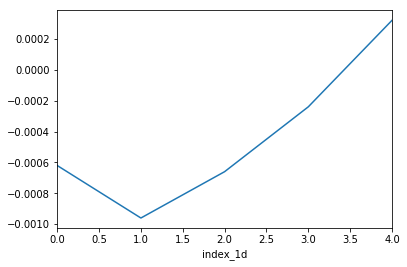

In [15]:
df.loc[0, 5]['lockin1x'].plot()

,amplitude,amplitude_error,b_external,file_index,gfactor,gfactor_error,n_repeats,phase_offset,phase_offset_error,pump_power,time_elapsed,wavelength,y_offset,y_offset_error
index_2d,,,,,,,,,,,,,,
0.0,1.860259e-03,8.521346,-0.300,10.0,-21.493517,7.683154e+04,1.0,-3.141288,2.343905e+04,93.0,4.0,818.01,0.001000,7.970192
1.0,7.691580e-06,NaN,0.000,21.0,0.439000,NaN,1.0,-3.132615,NaN,93.0,12.0,818.01,0.000402,NaN
2.0,1.582055e-03,2.225025,0.300,32.0,34.714533,3.282844e+04,1.0,-3.141531,1.139589e+04,93.0,20.0,818.01,0.001000,0.113713
3.0,3.774432e-03,0.227627,0.210,43.0,-58.128325,3.200331e+03,1.0,3.141429,7.395107e+02,93.0,28.0,818.01,0.001000,0.005014
4.0,2.122772e-04,0.000689,0.209,54.0,-1012.460910,1.319057e+03,1.0,-3.141592,3.140165e+02,93.0,36.0,818.01,-0.000354,0.000487
5.0,2.347916e-04,0.000918,0.208,65.0,-1407.290728,2.256557e+03,1.0,3.141563,5.310090e+02,93.0,44.0,818.01,-0.000435,0.000460
6.0,1.697872e-03,0.067924,0.207,71.0,-162.448332,3.547942e+03,1.0,3.141591,7.677125e+02,93.0,52.0,818.01,0.001000,0.042124
7.0,1.773579e-03,0.193699,0.206,72.0,-162.490749,9.276501e+03,1.0,3.141590,1.927754e+03,93.0,60.0,818.01,0.001000,0.137652
8.0,1.949977e-03,3.162629,0.205,73.0,51.924481,4.848151e+04,1.0,-3.141571,1.118153e+04,93.0,68.0,818.01,0.001000,0.177363


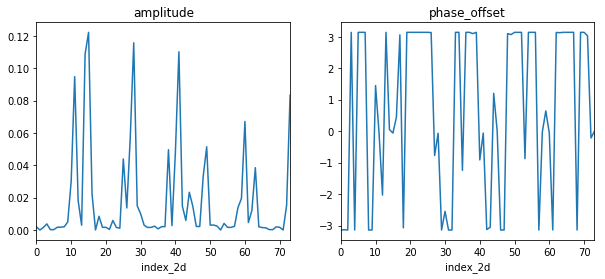

In [16]:
run_df = df.xs(0, level='run_id')
residuals_fcn = residuals_fitfcn_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "lockin1x"
column_aggregation_dict = {'time_elapsed': lambda x: x.tail(1).values}
keep_const_columns = True

dataset_results, new_df = \
    df_minimize_fcn_on_datasets(run_df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)
new_df = new_df.unstack()
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
new_df['amplitude'].plot.line(ax=ax1)
plt.title('amplitude')
ax2 = plt.subplot(1,2,2)
new_df['phase_offset'].plot.line(ax=ax2)
plt.title('phase_offset')
new_df

In [17]:
# df = TRKR_fit_dataframe
# df = df.reset_index()
# dfg = df.groupby(level=['run_id', 'index_2d', 'index_1d'])

# def fit_phase_to_TRKR_df(df):
#     return df

# df = dfg.apply(fit_phase_to_TRKR_df)



## ADVENTURE THROUGH THE QUIRKS OF PANDAS: trying to condense # values in a column by thresholding, binning

In [18]:
# Sorting run_id by experiment settings
# Goal is to be able to create to something like a n-dimensional pivot table,
# where data is run_id value
df = TRKR_fit_dataframe
df = df.reset_index()
df = df.groupby('run_id', as_index=False).first() # take only 1 representative row from each 2D scan

# 1. pump power categorization via thresholding
high_power_indices = df.pump_power > 1000
df['pump_power'] = 100
df.loc[high_power_indices, 'pump_power'] = 2500

# 2. wavelength categorization by condensing scattered values into N subgroups (N=?)
#df.plot.scatter('run_id','wavelength')
wlcats = pd.cut(df.wavelength, 10)  # crude grouping technique, but works on this set. TODO: k-means would be better

# BUG(?) WARNING: if you use df.groupby(wlcats).transform(series_transform_fcn),
# where series_transform_fcn is like method 2 below, but with
# "if series.name == 'wavelength':" guard, you get incredibly
# bizarre errors where transform stops working after 1st grouped
# dataframe, acting not on grouped df columns but
# instead on...wlcats' index (???), never returning to 2nd
# grouped dataframe. no error is thrown, and original df is returned.
# Also very sensitive to exact result of transform. Bizarre.

# method 1: act on entire grouped dataframes via apply()
#def replace_wavelength_with_group_mean(df):
#    df['wavelength'] = df['wavelength'].mean()
#    return df
#df = df.groupby(wlcats).apply(replace_wavelength_with_group_mean)

# method 2: transform wavelength column via groupby(...)[column name].transform(series_transform_fcn)
df.wavelength = df.wavelength.groupby(wlcats).transform(lambda x: x.mean())

df.wavelength = np.around(df.wavelength, decimals=2)  # nearest .01nm is plenty close, easier to read
df


,run_id,index_2d,index_1d,b_external,file_index,lockin1x,n_repeats,pump_power,probe_delay,time_elapsed,wavelength
0,0,0.0,0,-0.3,10,0.00062,1.0,100,-500.1108,0.0,818.01
1,1,0.0,0,-0.3,84,0.00102,1.0,100,-500.1108,0.0,818.23
2,2,0.0,0,-0.3,194,-0.00120,2.0,100,-500.0554,0.0,818.36
3,3,0.0,0,-0.3,329,-0.00124,2.0,100,-500.1108,0.0,818.77
4,4,0.0,0,-0.3,428,-0.00076,1.0,100,-500.0554,0.0,818.77
5,5,0.0,0,-0.3,502,-0.00036,1.0,100,-500.0554,0.0,819.05
6,6,0.0,0,-0.3,576,0.00160,1.0,100,-500.0000,0.0,819.41
7,7,0.0,0,-0.3,686,0.00124,2.0,100,-500.1108,0.0,819.05
8,8,0.0,0,-0.3,785,-0.00010,1.0,2500,-500.0000,0.0,818.01
9,9,0.0,0,-0.3,895,0.00232,2.0,2500,-500.0554,0.0,818.36


In [19]:
# Run settings pivot table summary!
# PANDAS QUIRK WARNING: aggregation function _must_ use tuples, NOT lists. No lists in DataFrames.
tuple_concat = lambda x: sum([(val,) for val in x], ())
pvt = df.pivot_table(values='run_id',
#                     index=['wavelength', 'n_repeats'],
                     index=['wavelength'],
                     columns=['pump_power'],
                     aggfunc=tuple_concat)
pvt

pump_power,100,2500
wavelength,,
818.01,"(0,)","(8,)"
818.23,"(1,)","(10,)"
818.36,"(2,)","(9,)"
818.77,"(3, 4)","(12, 13)"
819.05,"(5, 7)","(14, 15)"
819.41,"(6,)","(11,)"


In [20]:
pvt.values

array([[(0,), (8,)],
       [(1,), (10,)],
       [(2,), (9,)],
       [(3, 4), (12, 13)],
       [(5, 7), (14, 15)],
       [(6,), (11,)]], dtype=object)

In [21]:
# Plot TRKR vs B-field in 2D
plot_run_id = 10

def plot_trkr_vs_bexternal(dataframe, run_id):
    plot_df = dataframe.loc[run_id]  # .loc[plot_run_id, :, :] keeps run_id label
    plot_df = plot_df.unstack('index_1d')
    xvals_df = plot_df['probe_delay']  # pd.DataFrames, meshgrid()-style 
    yvals_df = plot_df['b_external']
    zvals_df = plot_df[data_yfield]
    xvals_s = xvals_df.iloc[0]  # pd.Series w/matching x-dimensional indexing
    yvals_s = yvals_df.T.iloc[0]

    x_label_indices, x_label_values = xvals_s.index, xvals_s.values
    x_labels = ["{:.1f} ns".format(val / 1000)
                for val in x_label_values]
    y_labeL_indices, y_label_values = get_inflection_points(yvals_s)
    y_labels = ["{:d} mT".format(int(val * 1000))
                for val in y_label_values]
    plot_label_column_names = ['wavelength', 'pump_power']
    plotlabel = "\n".join(['{}: {}'.format(colname, dataframe.loc[run_id][colname].iloc[0])
                           for colname in plot_label_column_names])

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111)
    ax.imshow(zvals_df, cmap='jet', interpolation='nearest', aspect=0.8 * len(xvals_s) / len(yvals_s))
    ax.text(1.1, 0.9, plotlabel, verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, color='black', fontsize=16)
    plt.xticks(x_label_indices, x_labels)
    plt.yticks(y_labeL_indices, y_labels)
    plt.show()

run_id_slider = widgets.IntSlider(min=0, max=TRKR_fit_dataframe.index.get_level_values('run_id').max(),
                                  value=0, description='Run ID:')
widgets.interact(plot_trkr_vs_bexternal,
                 dataframe=widgets.fixed(TRKR_fit_dataframe),
                 run_id=run_id_slider);


In [22]:
slow_RSA_dataframe = full_dataframe.query('scancoord > 1.0 or scancoord < -1.0')  # can't be b-field, ensures TRKR
slow_RSA_dataframe.query('b_external < 0.3 and b_external > 0', inplace=True)
slow_RSA_dataframe.rename(columns={'scancoord': 'probe_delay'}, inplace=True)
slow_RSA_dataframe.set_index(['run_id', 'index_1d', 'index_2d'], drop=False, append=False, inplace=True)
slow_RSA_dataframe.sort_index(ascending=True, inplace=True)
slow_RSA_dataframe.head(10)

b_external  file_index  index_1d  index_2d  \
run_id index_1d index_2d                                               
0      0        3.0            0.210          43         0       3.0   
                4.0            0.209          54         0       4.0   
                5.0            0.208          65         0       5.0   
                6.0            0.207          71         0       6.0   
                7.0            0.206          72         0       7.0   
                8.0            0.205          73         0       8.0   
                9.0            0.204           0         0       9.0   
                10.0           0.203           1         0      10.0   
                11.0           0.202           2         0      11.0   
                12.0           0.201           3         0      12.0   

                          lockin1x  n_repeats  pump_power  run_id  \
run_id index_1d index_2d                                            
0      0        3.0       -0.00080        1.0        93.0       0   
                4.0       -0.00066        1.0        93.0       0   
                5.0       -0.00062        1.0        93.0       0   
                6.0       -0.00038        1.0        93.0       0   
                7.0       -0.00028        1.0        93.0       0   
                8.0        0.00004        1.0        93.0       0   
                9.0        0.00092        1.0        93.0       0   
                10.0       0.00272        1.0        93.0       0   
                11.0       0.00126        1.0        93.0       0   
                12.0      -0.00004        1.0        93.0       0   

                          probe_delay  time_elapsed  wavelength  
run_id index_1d index_2d                                         
0      0        3.0         -500.1108          24.0      818.01  
                4.0         -500.1108          32.0      818.01  
                5.0         -500.1108          40.0      818.01  
                6.0         -500.1108          48.0      818.01  
                7.0         -500.1108          56.0      818.01  
                8.0         -500.1108          64.0      818.01  
                9.0         -500.1108          72.0      818.01  
                10.0        -500.1108          80.0      818.01  
                11.0        -500.1108          88.0      818.01  
                12.0        -500.1662          96.0      818.01

name: (0, 32.0)
data:


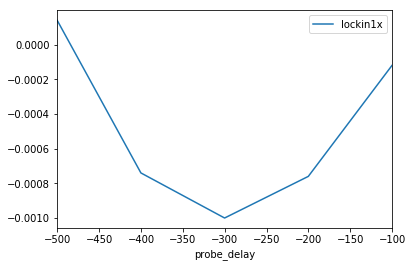

In [23]:
# examining the contents of a groupby()
grouping = TRKR_fit_dataframe.groupby(level=['run_id', 'index_2d'])
group_names, group_dataframes = zip(*[(name, df)
                                      for name, df in grouping])
ind = 32
group_name = group_names[ind]
group_dataframe = group_dataframes[ind]
print('name: ' + str(group_name))
print('data:')
#group_dataframe
group_dataframe.plot.line(x='probe_delay', y='lockin1x', legend=True)